# Logistic Regression (Coffees dataset)

In [16]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


## Load raw data and plot

In [17]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/coffees/FTIR_instant_coffees.csv')
data.head(5)

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code,label
0,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,1,Arabica
1,10.364243,10.569554,10.448875,10.100696,9.620371,8.882499,8.415529,8.210217,7.916430,7.806151,...,1.493133,1.475563,1.464682,1.456444,1.442087,1.433698,1.425288,1.418705,1,Arabica
2,13.118324,13.507084,13.473495,12.871428,12.181919,11.239480,10.515672,10.468178,10.428742,10.212771,...,2.236715,2.214229,2.196218,2.181646,2.164602,2.146423,2.133255,2.121559,1,Arabica
3,15.668409,15.803868,15.977607,15.569489,14.950423,14.029599,13.396739,13.092360,12.784991,12.829988,...,3.020125,2.987411,2.963816,2.954810,2.942520,2.909018,2.880989,2.876201,1,Arabica
4,16.634960,17.055263,17.610495,17.211594,16.217897,15.287751,14.424133,13.928921,13.551499,13.288979,...,3.310964,3.281866,3.263161,3.241584,3.213549,3.183820,3.157357,3.146584,1,Arabica


In [18]:
# shuffle data rows
data = data.sample(frac=1)

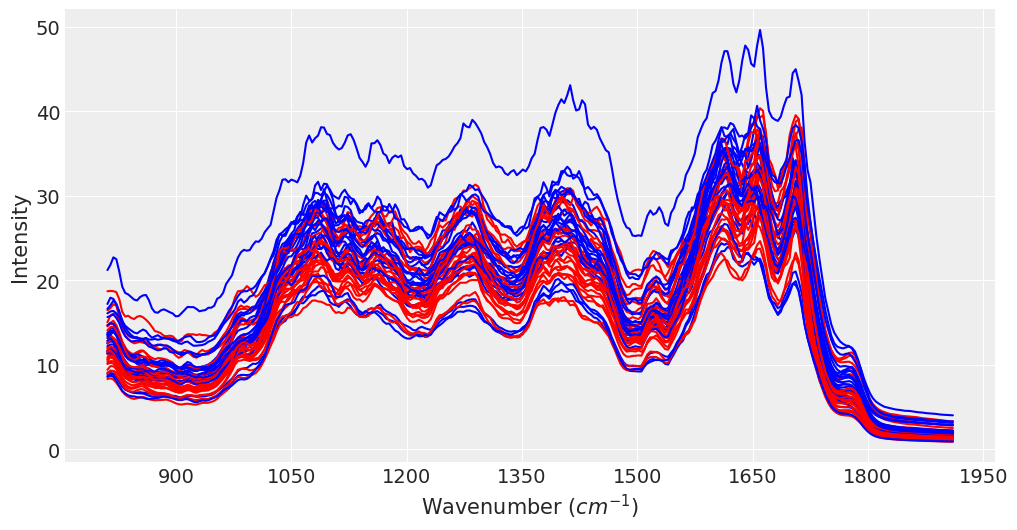

In [19]:
# number of non-data columns at right of dataframe
ndata_cols = -2

# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity')

for i in range(50):
    y_val = data.values[i]
    if y_val[-1] == 'Arabica':
        col = 'blue'
    else:
        col = 'red'
    plt.plot(x_val, y_val[:ndata_cols], '-', color=col);

In [20]:
# number of samples from each class
data['label'].value_counts()

Arabica    29
Robusta    27
Name: label, dtype: int64

In [21]:
# generate training and test sets
train_data, test_data = train_test_split(data, test_size=0.33, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [22]:
test_data.shape

(19, 288)

In [23]:
train_data.shape

(37, 288)

# Model definition (Multiple Logistic Regression)
The following statistical model is assumed:

\begin{equation}
\alpha \sim \mathcal{N}(\mu_{\alpha},\,\sigma^{2}_{\alpha}) \\
\beta \sim \mathcal{N}(\mu_{\beta},\,\sigma^{2}_{\beta}) \\
\theta = logistic(\alpha+\beta X) \\
y \sim Bernoulli(\theta)
\end{equation}

In [24]:
# standardize data
Y = pd.Categorical(train_data['label']).codes
x_n = train_data.columns[:ndata_cols]
x_s = train_data[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)
x_s.shape

(37, 286)

In [25]:
with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_s, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
     
    y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 
 
    trace_mlr = pm.sample(2000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [15:38<00:00,  5.33draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


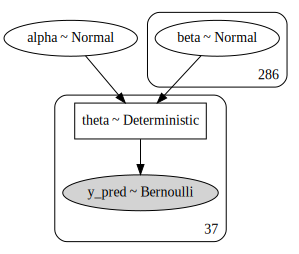

In [26]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [27]:
varnames = ['alpha', 'beta']
coef = az.summary(trace_mlr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.682,11.337,-22.519,20.862,0.220,0.177,2654.0,2055.0,2706.0,2243.0,1.0
beta[0],1.538,9.579,-15.694,20.400,0.146,0.159,4330.0,1806.0,4324.0,2866.0,1.0
beta[1],1.163,9.842,-16.993,19.854,0.137,0.178,5166.0,1536.0,5168.0,2667.0,1.0
beta[2],0.986,9.682,-17.597,18.213,0.145,0.180,4486.0,1450.0,4462.0,2808.0,1.0
beta[3],1.144,10.020,-18.065,18.876,0.164,0.161,3735.0,1938.0,3738.0,2812.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[281],-1.498,10.167,-20.631,16.478,0.150,0.173,4580.0,1730.0,4574.0,2643.0,1.0
beta[282],-1.535,10.154,-18.819,19.425,0.144,0.181,4945.0,1568.0,4930.0,2703.0,1.0
beta[283],-1.381,9.881,-18.800,17.854,0.158,0.173,3902.0,1629.0,3914.0,2610.0,1.0
beta[284],-1.593,9.876,-19.824,16.770,0.157,0.171,3949.0,1678.0,3965.0,2678.0,1.0


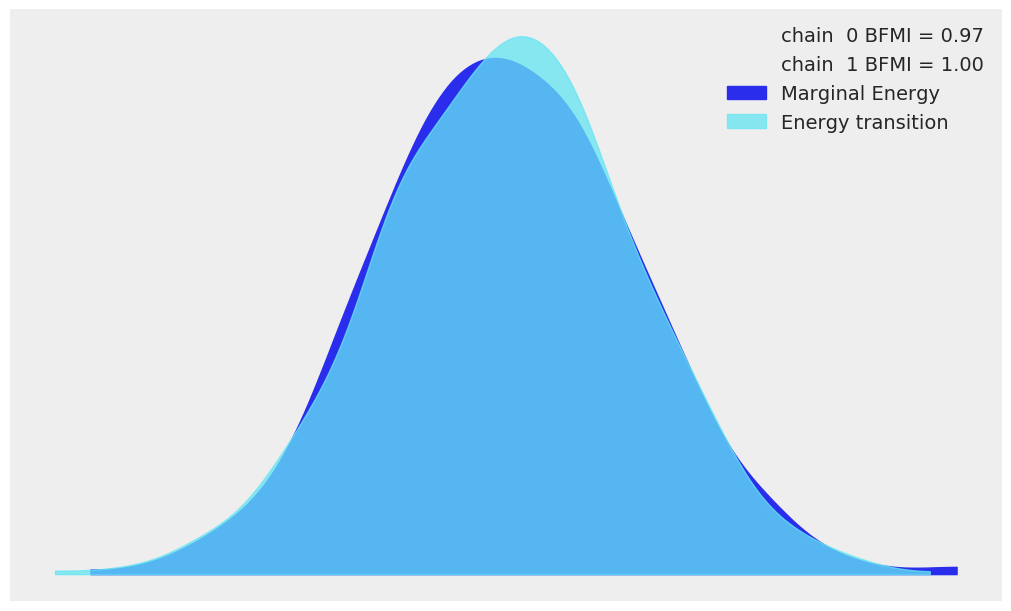

In [28]:
#az.plot_forest(trace_mlr, var_names=varnames, combined=True);
az.plot_energy(trace_mlr, figsize=(10, 6));

In [29]:
# check model predictions on test dataset
a = trace_mlr['alpha'].mean()
b = trace_mlr['beta'].mean(axis=0)

xt_n = test_data.columns[:ndata_cols]
xt_s = test_data[x_n].values
xt_s = (xt_s - xt_s.mean(axis=0)) / xt_s.std(axis=0)

mu_t = a + (b * xt_s).sum(axis=1)
yt_p = 1 / (1 + np.exp(-mu_t))

pt_y = np.zeros(len(xt_s))
lp_t = [] 

for i in range(len(xt_s)):
    if (yt_p[i] < 0.5): 
        pt_y[i] = 0
        lp_t.append('Arabica')
    else:
        pt_y[i] = 1
        lp_t.append('Robusta')
        
test_data = test_data.assign(pred=pd.Series(pt_y))
test_data = test_data.assign(pred_label=pd.Series(lp_t))
test_data.iloc[:,(ndata_cols-2):]

,code,label,pred,pred_label
0,2,Robusta,1.0,Robusta
1,1,Arabica,0.0,Arabica
2,2,Robusta,1.0,Robusta
3,1,Arabica,0.0,Arabica
4,2,Robusta,1.0,Robusta
5,1,Arabica,0.0,Arabica
6,2,Robusta,1.0,Robusta
7,1,Arabica,0.0,Arabica
8,1,Arabica,0.0,Arabica
9,1,Arabica,0.0,Arabica


In [30]:
# prediction score on test dataset (%)
Yt = pd.Categorical(test_data['label']).codes
c = 0
for i in range(len(xt_s)):
    if test_data['label'].iloc[i] == lp_t[i]:
        c += 1
        
f'{c/len(Yt) * 100:.1f}'

'100.0'